<a href="https://colab.research.google.com/github/anvitha-jain/MLColab/blob/master/Factor_BERT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# 1. Preparation


## 1.1 Set parameters

In [0]:
## parameters Setting
par_cased = 0 # default cased, 0 means uncased
par_cleanup = 1 # default cleanup, 0 means non-cleanup
par_eda = 1 # default eda, 0 means non-eda

In [6]:
!pip install pytorch_pretrained_bert nlpaug bert matplotlib sklearn librosa SoundFile nltk pandas

In [0]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from random import randrange
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf
from nlpaug.util import Action

## 1.2 Set tokenizer

In [8]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
if par_cased ==1:
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


## 1.3 Define Bert config

In [0]:
class BertLayerNorm(nn.Module):
        def __init__(self, hidden_size, eps=1e-12):
            """Construct a layernorm module in the TF style (epsilon inside the square root).
            """
            super(BertLayerNorm, self).__init__()
            self.weight = nn.Parameter(torch.ones(hidden_size))
            self.bias = nn.Parameter(torch.zeros(hidden_size))
            self.variance_epsilon = eps

        def forward(self, x):
            u = x.mean(-1, keepdim=True)
            s = (x - u).pow(2).mean(-1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.variance_epsilon)
            return self.weight * x + self.bias
        

class BertForSequenceClassification(nn.Module):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary. Items in the batch should begin with the special "CLS" token. (see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].
    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].
    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
    num_labels = 2
    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, num_labels=2):
        super(BertForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        if par_cased ==1:
            self.bert = BertModel.from_pretrained('bert-base-cased')
        else:
            self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        nn.init.xavier_normal_(self.classifier.weight)
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

In [0]:
# !pip install pytorch_pretrained_bert pytorch-nlp

In [11]:
from pytorch_pretrained_bert import BertConfig

config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

num_labels = 2
model = BertForSequenceClassification(num_labels)

# Convert inputs to PyTorch tensors
# tokens_tensor = torch.tensor([tokenizer.convert_tokens_to_ids(zz)])

# logits = model(tokens_tensor)

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp2y3uiojv
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



# 2. Dataset Processing

In [12]:
import pandas as pd

dat = pd.read_csv('/content/drive/My Drive/fake_or_real_news.csv')
dat.head()

,Unnamed: 0,title,text,label,title_vectors
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,[ 1.1533764e-02 4.2144405e-03 1.9692603e-02 ...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,[ 0.11267698 0.02518966 -0.00212591 0.021095...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,[ 0.04253004 0.04300297 0.01848392 0.048672...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,[ 0.10801624 0.11583211 0.02874823 0.061732...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,[ 1.69016439e-02 7.13498285e-03 -7.81233795e-...


## 2.1 Convert label into binary text

In [13]:
dat = dat.drop(columns=['Unnamed: 0', 'title_vectors'])
for i in range(len(dat)):
    if dat.loc[i, 'label'] == "REAL": #REAL equal 0
        dat.loc[i, 'label'] = 0
    elif dat.loc[i, 'label'] == "FAKE": #FAKE equal 1
        dat.loc[i, 'label'] = 1
    if dat.loc[i, 'text'] == "":
        dat = dat.drop([i])
dat.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


## 2.2 Combine the title and text

In [14]:
dat_plus = dat.copy()
dat_plus['title_text']=dat['title']+'. '+dat['text']
dat_plus = dat_plus.drop(columns=['title', 'text'])

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [15]:
dat_plus['title_text']

0       You Can Smell Hillary’s Fear. Daniel Greenfiel...
1       Watch The Exact Moment Paul Ryan Committed Pol...
2       Kerry to go to Paris in gesture of sympathy. U...
3       Bernie supporters on Twitter erupt in anger ag...
4       The Battle of New York: Why This Primary Matte...
                              ...                        
6330    State Department says it can't find emails fro...
6331    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332    Anti-Trump Protesters Are Tools of the Oligarc...
6333    In Ethiopia, Obama seeks progress on peace, se...
6334    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: title_text, Length: 6335, dtype: object

## 2.3 Use regular expression to drop non-sentence

In [0]:
import re
def cleanup(text):
    # print(type(text))
    if par_cased == 0: # transfer into lower text if par_cased is false
        text = text.lower()
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text) # drop http[s]://*
    text = re.sub(u"\\{.*?}|\\[.*?]",'',text) # drop [*]
    text = re.sub(u"\(\@.*?\s", '', text) # drop something like (@EP_President)
    text = re.sub(u"\@.*?\s", '', text) # drop soething liek @EP_President
    text = re.sub(u"\#.*?\s", '', text) # drop something like #EP_President (maybe hashtag)
    text = re.sub(u"\© .*?\s", '', text) # drop something like © EP_President
    text = re.sub(r'pic.tw(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text) # drop pic.twitter.com/*
    text = re.sub(u"\*\*", '', text) # drop something like **Want FOX News First * in your inbox every day? Sign up here.**
    text = re.sub(u"|•|☮️|💚|🌍|😍|♦|☢", '', text) # drop something like  and • etc
    return(text)

## 2.4 Use Easy Data Augmentation techniques (EDA) method to augment the text

EDA consists of four simple operations that do a surprisingly good job at preventing overfitting and helping train more robust models. Here they are:

- Synonym Replacement: Randomly choose n words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random.

- Random Insertion: Find a random synonym of a random word in the sentence that is not a stop word. Insert that synonym into a random position in the sentence. Do this n times.

- Random Swap: Randomly choose two words in the sentence and swap their positions. Do this n times.

- Random Deletion: Randomly remove each word in the sentence with probability p.

In [17]:
import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:

# if par_cased ==1:
#     aug = naf.Sequential([
#         naw.BertAug(action="substitute", aug_p=0.8, aug_n=20,model_path='bert-base-cased',tokenizer_path='bert-base-cased'),
#         naw.BertAug(action="insert", aug_p=0.1)
#     ])
# else:
#     aug = naf.Sequential([
#         naw.BertAug(action="substitute", aug_p=0.8, aug_n=20,model_path='bert-base-uncased',tokenizer_path='bert-base-uncased'),
#         naw.BertAug(action="insert", aug_p=0.1)
#     ])

# def aug_text(text):
#     text = aug.augment(text)
#     return(text)
from nltk.tokenize import sent_tokenize
def sentence_token_nltk(text):
    sent_tokenize_list = sent_tokenize(text)
    return sent_tokenize_list
def eda_text(text):
    if len(text) < 2:
        return(text)
    # split text into sentences
    text = sentence_token_nltk(text)
    if len(text) <= 1:
        return(text)
    if len(text) == 2:
        for i in range(len(text)):
            if i == 0:
                tmp_text = text[i]
            else:
                tmp_text += text[i]
        return(tmp_text)
    # operate prior 3 sentences
    for i in range(3):
        if i == 0:
            tmp_text = text[i]
        else:
            tmp_text += text[i]
    zz = tokenizer.tokenize(tmp_text)
    # operate proper sentences
    # if len(zz) <= 500:
    # #print(len(zz))
    #     tmp_text = aug_text(tmp_text)
    # conbine prior 3 sentences and rest sentences
    for j in range(len(text)-3):
        tmp_text += text[j+3]
    return(tmp_text)

In [19]:
if par_eda == 1: # use eda to operate sentences when par_eda is true
  for i in range(len(dat_plus['title_text'])):
      if i%6 == 1:       
          print(i)
          dat_plus['title_text'][i] = copy.deepcopy(eda_text(dat_plus['title_text'][i]))
          dat_plus['title_text'][i] = "".join(dat_plus['title_text'][i])

1
7
13
19
25
31
37
43
49
55
61
67
73
79
85
91
97
103
109
115
121
127
133
139
145
151
157
163
169
175
181
187
193
199
205
211
217
223
229
235
241
247
253
259
265
271
277
283
289
295
301
307
313
319
325
331
337
343
349
355
361
367
373
379
385
391
397
403
409
415
421
427
433
439
445
451
457
463
469
475
481
487
493
499
505
511
517
523
529
535
541
547
553
559
565
571
577
583
589
595
601
607
613
619
625
631
637
643
649
655
661
667
673
679
685
691
697
703
709
715
721
727
733
739
745
751
757
763
769
775
781
787
793
799
805
811
817
823
829
835
841
847
853
859
865
871
877
883
889
895
901
907
913
919
925
931
937
943
949
955
961
967
973
979
985
991
997
1003
1009
1015
1021
1027
1033
1039
1045
1051
1057
1063
1069
1075
1081
1087
1093
1099
1105
1111
1117
1123
1129
1135
1141
1147
1153
1159
1165
1171
1177
1183
1189
1195
1201
1207
1213
1219
1225
1231
1237
1243
1249
1255
1261
1267
1273
1279
1285
1291
1297
1303
1309
1315
1321
1327
1333
1339
1345
1351
1357
1363
1369
1375
1381
1387
1393
1399
1405
1411
1417
1

# 3. Google Bert

In [0]:
import torch.nn.functional as F

# F.softmax(logits,dim=1)

In [0]:
from sklearn.model_selection import train_test_split
if par_cleanup == 1:
    X = dat_plus['title_text'].apply(cleanup)
else:
    X = dat_plus['title_text']
y = dat_plus['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

y_train = pd.get_dummies(y_train).values.tolist() # convert to one-hot encoding
y_test = pd.get_dummies(y_test).values.tolist()

In [0]:
max_seq_length = 256
class text_dataset(Dataset):
    def __init__(self,x_y_list, transform=None):
        
        self.x_y_list = x_y_list
        self.transform = transform
        
    def __getitem__(self,index):
        
        tokenized_title_text = tokenizer.tokenize(self.x_y_list[0][index])
        
        if len(tokenized_title_text) > max_seq_length:
            tokenized_title_text = tokenized_title_text[:max_seq_length]
            
        ids_title_text  = tokenizer.convert_tokens_to_ids(tokenized_title_text) #tokens->input_ids

        padding = [0] * (max_seq_length - len(ids_title_text))
        
        ids_title_text += padding # use padding to make the same ids
        
        assert len(ids_title_text) == max_seq_length
        
        #print(ids_title_text)
        ids_title_text = torch.tensor(ids_title_text)
        
        label = self.x_y_list[1][index] # color        
        list_of_labels = [torch.from_numpy(np.array(label))]
        
        
        return ids_title_text, list_of_labels[0]
    
    def __len__(self):
        return len(self.x_y_list[0])

## 3.1 Create data dictionary

In [24]:
batch_size = 16 # divide into 16 batches

train_lists = [X_train, y_train]
test_lists = [X_test, y_test]

training_dataset = text_dataset(x_y_list = train_lists )

test_dataset = text_dataset(x_y_list = test_lists )

dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
                   'val':torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                  }                
dataset_sizes = {'train':len(train_lists[0]),
                'val':len(test_lists[0])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
print(device)

cuda:0


## 3.2 Define the train model

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):    
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100
    best_f1 = 0.978
    best_acc_test = 0.96
    best_acc_train = 0.96
    best_auc = 0.96
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            label_corrects = 0
            TP = 0
            TN = 0
            FN = 0
            FP = 0
            total_scores = []
            total_tar = []
            # Iterate over data.
            for inputs, label in dataloaders_dict[phase]:
                #inputs = inputs
                #print(len(inputs),type(inputs),inputs)
                #inputs = torch.from_numpy(np.array(inputs)).to(device) 
                inputs = inputs.to(device) 
                label = label.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #print(inputs)
                    outputs = model(inputs)

                    outputs = F.softmax(outputs,dim=1)
                    
                    loss = criterion(outputs, torch.max(label.float(), 1)[1])
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                label_corrects += torch.sum(torch.max(outputs, 1)[1] == torch.max(label, 1)[1]) #返回每一行中最大值的那个元素，且返回其索引（返回最大元素在这一行的列索引）
                pred_choice = torch.max(outputs, 1)[1]
                target = torch.max(label, 1)[1]
                scores = pred_choice.cpu().tolist()
                tar = target.cpu().tolist()
                total_scores = total_scores + scores
                total_tar = total_tar + tar

                tmp_tp = 0
                tmp_tn = 0
                tmp_fn = 0
                tmp_fp = 0
                if pred_choice.numel()!= target.numel():
                    print("error")
                for i in range(pred_choice.numel()):
                    if pred_choice[i] == 1 and target[i] == 1 :
                        tmp_tp = tmp_tp + 1
                    elif pred_choice[i] == 0 and target[i] == 0 :
                        tmp_tn = tmp_tn + 1
                    elif pred_choice[i] == 0 and target[i] == 1 :
                        tmp_fn = tmp_fn + 1
                    elif pred_choice[i] == 1 and target[i] == 0 :
                        tmp_fp = tmp_fp + 1
                # TP    both predict and label are 1
                TP += tmp_tp
                # TN    both predict and label are 0
                TN += tmp_tn
                # FN    predict 0 label 1
                FN += tmp_fn
                # FP    predict 1 label 0
                FP += tmp_fp
            epoch_loss = running_loss / dataset_sizes[phase]
            p = TP / (TP + FP)
            r = TP / (TP + FN)
            F1 = 2 * r * p / (r + p)
            acc = (TP + TN) / (TP + TN + FP + FN)

            ### draw ROC curce
            tpr = TP/(TP+FN)
            fpr = FP/(FP+TN)
            tnr = TN/(FP+TN)

            total_scores = np.array(total_scores)
            total_tar = np.array(total_tar)
            fpr, tpr, thresholds = roc_curve(total_tar, total_scores)
            roc_auc = auc(fpr, tpr) 
            plt.title('ROC')
            if roc_auc > best_auc:
                best_auc = roc_auc
            if epoch < num_epochs -1:
                plt.plot(fpr, tpr,'b',label='AUC = %0.4f'% roc_auc)
            if epoch == num_epochs -1:
                plt.plot(fpr, tpr, color='darkorange', label='MAX AUC = %0.4f'% best_auc) 
            plt.legend(loc='lower right')
            plt.plot([0,1],[0,1],'r--')
            plt.ylabel('TPR')
            plt.xlabel('FPR')
            plt.show()

            #print('{} p: {:.4f} '.format(phase,p ))
            #print('{} r: {:.4f} '.format(phase,r ))
            print('{} F1: {:.4f} '.format(phase,F1 ))
            print('{} accuracy: {:.4f} '.format(phase,acc ))

            if phase == 'val' and epoch_loss < best_loss:
                print('saving with loss of {}'.format(epoch_loss),
                      'improved over previous {}'.format(best_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                #torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/bert_model_test_loss.pth')
            if F1 > best_f1:
                best_f1 = F1
            if phase == 'val' and acc > best_acc_test:
                best_acc_test = acc
            if phase == 'train' and acc > best_acc_train:
                best_acc_train = acc
                #best_model_wts = copy.deepcopy(model.state_dict())
                #torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/bert_model_test_f1.pth')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print("Parament setting: ")
    print("cased: ",par_cased)
    print("cleanup: ",par_cleanup)
    print("eda: ",par_eda)
    print('Best train Acc: {:4f}'.format(float(best_acc_train)))
    print('Best test Acc: {:4f}'.format(float(best_acc_test)))
    print('Best f1 score: {:4f}'.format(float(best_f1)))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 4. Final Output

## 4.1 Model details

In [26]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [27]:
model.to(device)

#model.freeze_bert_encoder()
#model.classifier.weight.requires_grad = True
#    def freeze_bert_encoder(self):
#        for param in self.bert.parameters():
#            param.requires_grad = False
#    
#    def unfreeze_bert_encoder(self):
#        for param in self.bert.parameters():
#            param.requires_grad = True

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
lrlast = .001
lrmain = .00001
optim1 = optim.Adam(
    [
        {"params":model.bert.parameters(),"lr": lrmain},
        {"params":model.classifier.parameters(), "lr": lrlast},
       
   ])

#optim1 = optim.Adam(model.parameters(), lr=0.001)#,momentum=.9)
# Observe that all parameters are being optimized
optimizer_ft = optim1
criterion = nn.CrossEntropyLoss() # loss function

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

## 4.2 F1 and other para details

starting
Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


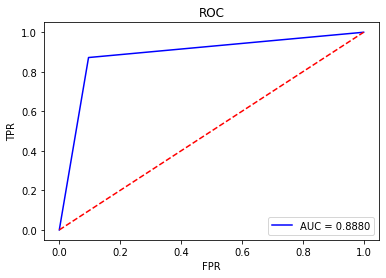

train F1: 0.8853 
train accuracy: 0.8881 


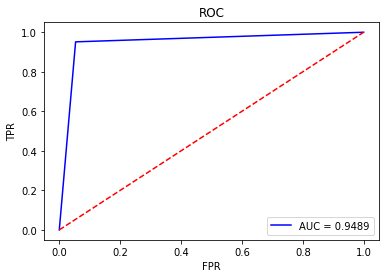

val F1: 0.9500 
val accuracy: 0.9490 
saving with loss of 0.36194135680567396 improved over previous 100

Epoch 1/9
----------


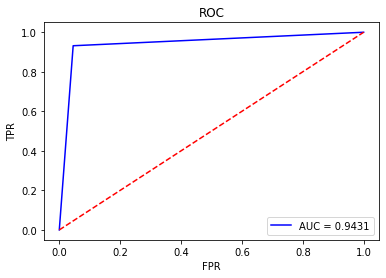

train F1: 0.9420 
train accuracy: 0.9432 


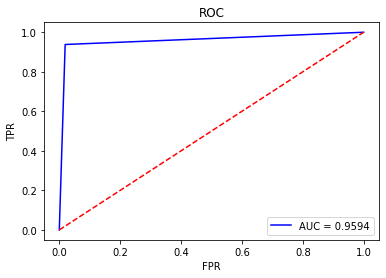

val F1: 0.9588 
val accuracy: 0.9590 
saving with loss of 0.3526385567302393 improved over previous 0.36194135680567396

Epoch 2/9
----------


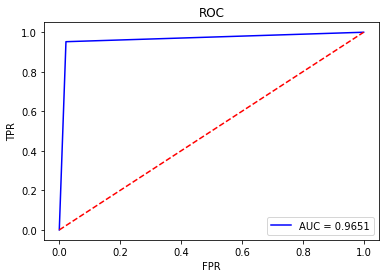

train F1: 0.9645 
train accuracy: 0.9653 


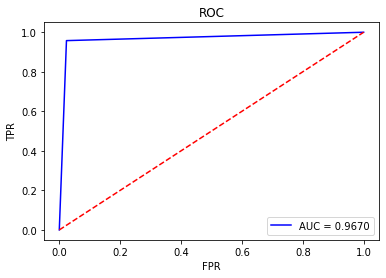

val F1: 0.9671 
val accuracy: 0.9669 
saving with loss of 0.3466916621233024 improved over previous 0.3526385567302393

Epoch 3/9
----------


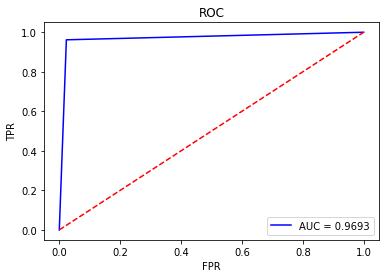

train F1: 0.9688 
train accuracy: 0.9693 


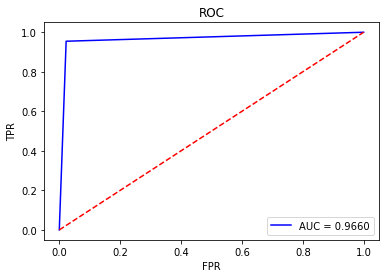

val F1: 0.9660 
val accuracy: 0.9658 
saving with loss of 0.3457775747913991 improved over previous 0.3466916621233024

Epoch 4/9
----------


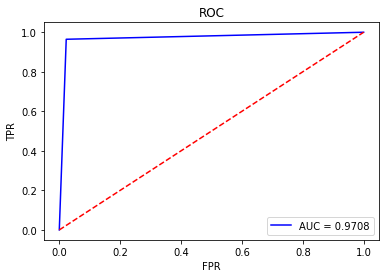

train F1: 0.9704 
train accuracy: 0.9709 


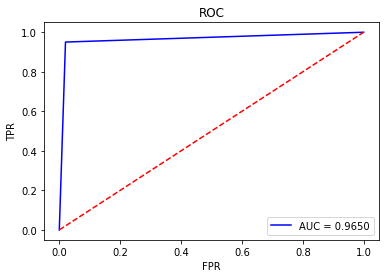

val F1: 0.9649 
val accuracy: 0.9648 

Epoch 5/9
----------


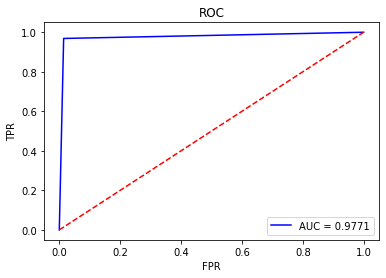

train F1: 0.9768 
train accuracy: 0.9772 


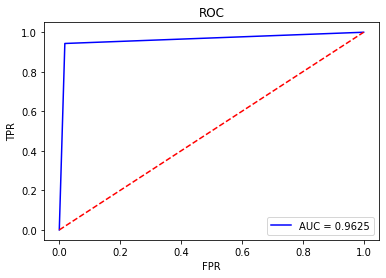

val F1: 0.9621 
val accuracy: 0.9621 

Epoch 6/9
----------


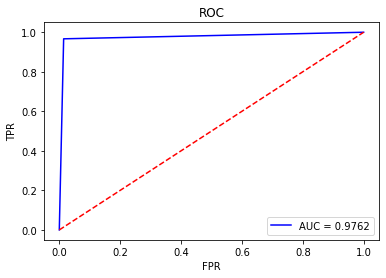

train F1: 0.9759 
train accuracy: 0.9763 


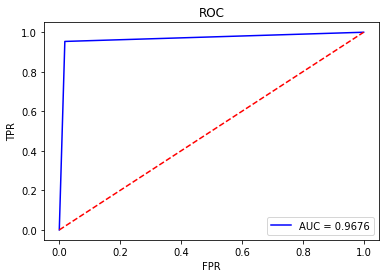

val F1: 0.9675 
val accuracy: 0.9674 

Epoch 7/9
----------


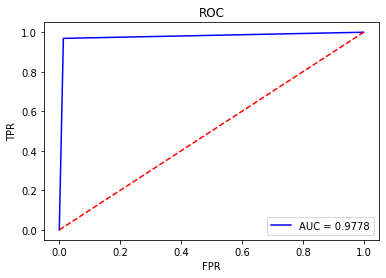

train F1: 0.9775 
train accuracy: 0.9779 


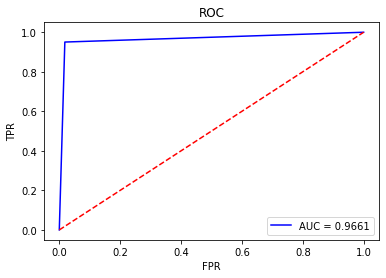

val F1: 0.9659 
val accuracy: 0.9658 

Epoch 8/9
----------


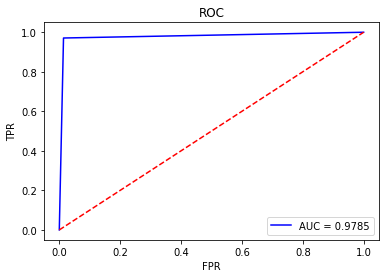

train F1: 0.9782 
train accuracy: 0.9786 


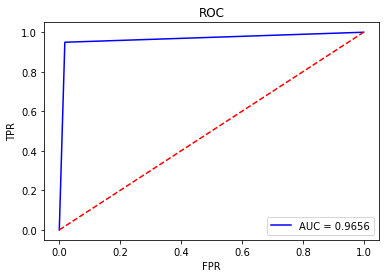

val F1: 0.9653 
val accuracy: 0.9653 

Epoch 9/9
----------


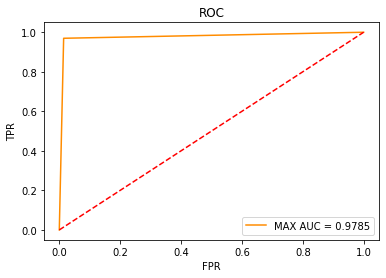

train F1: 0.9773 
train accuracy: 0.9777 


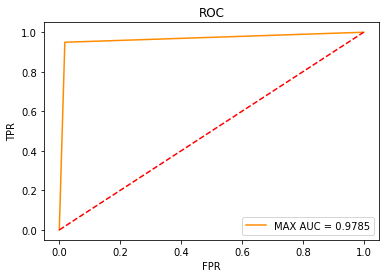

val F1: 0.9653 
val accuracy: 0.9653 

Training complete in 35m 49s
Parament setting: 
cased:  0
cleanup:  1
eda:  1
Best train Acc: 0.978575
Best test Acc: 0.967386
Best f1 score: 0.978206


In [29]:
model_ft1 = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)